In [2]:
!pip install qiskit
!pip install pylatexenc
!pip install matplotlib
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=92f53b1a137e0beb298df077f1678bf92ec5d35b306f57da9b474a54d9887d9d
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 108.8 MB/s eta 0:00:00


In [3]:
#////////////////////////////////////
# -- 1-body --
def U_C_1body(qc, c, gamma, qbs):
    # ---[ 2*C*gamma] --->
    # konstanta c, taruh dimana?
    qc.rz(2*c*gamma, qbs)
#
# -- 2-body --
def U_C_2body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.rz(2*c*gamma, qbs[1])
    qc.cx(qbs[0], qbs[1])
    # no return, assume qml global

# -- 3-body --
def U_C_3body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.cx(qbs[1], qbs[2])
    #
    qc.rz(2*c*gamma, qbs[2])
    #
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[0], qbs[1])

# -- 4-body --
def U_C_4body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[2], qbs[3])
    #
    qc.rz(2*c*gamma, qbs[3])
    #
    qc.cx(qbs[2], qbs[3])
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[0], qbs[1])
#--

###
def term_2_qidx(term):
    # ---------------------------------------------------------
    # convert energy/hamiltonian terms into coefficient and
    # indices of qubit
    # --- qubit ordering may not follow the terms: ??
    # input: term (symbolic)
    # output: [coeff, [qidx0, qidx1, ...]]
    # ---------------------------------------------------------
    coeff=1.0
    #split term into atoms
    atm=term.atoms()
    N=len(atm)
    qlist=list()
    for n in range (0,N):
        ts=atm.pop()
        if ts.is_number:
            coeff=float(ts)
        else:
            ss=str(ts)
            qidx=int(ss[1:])
            qlist.append(qidx)
    #//// sort the qubit list
    qlist.sort()
    return [coeff, qlist]

#
def efunct_2_qidx(Esym):
    #
    #
    Eterms=Esym.args
    # number of term
    N=len(Eterms)
    qxlist=list()
    for n in range(0,N):
        tterm=Eterms[n]
        qidx=term_2_qidx(tterm)
        #print(n,'>',tterm,'>>',qidx )
        qxlist.append(qidx)
    return(qxlist)
#
# //////////////////////////////////////////////////
# sudah jalan untuk order:
# //////////////////////////////////////////////////
def create_qaoa_circ_from_terms(qx, n_qubits, theta):
    """
    Creates a parametrized qaoa circuit from terms
    Args:
        qx: list of terms
        n_qubits: number of qubits
        theta: array of angle parameters
    Returns:
        qc: qiskit circuit
    """
    nqubits = n_qubits # len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    #--
    gamma = theta[:p]
    beta = theta[p:]
    #beta=theta[0]
    #gamma=theta[1]
    # initial_state
    #print('gamma>>', gamma)
    for i in range(0, nqubits):
        qc.h(i)
    ##--
    qc.barrier()
    #p=N_LAYER #### number of layer, set here
    #print('N_Layer->',p)
    ##
    for irep in range(0, p):
        for n in range(0,len(qx)):
            tqx=qx[n]
            #print(n,'>>',qx[n] )
            if len(tqx[1])==1:
                # 1-body
                #print('1-body>', tqx)
                #if len(tqx[1])>0:
                U_C_1body(qc, tqx[0], gamma[irep], tqx[1])
            #
            else:
                if len(tqx[1])==2:
                    #2-body
                    #print('2-body>', tqx)
                    U_C_2body(qc, tqx[0], gamma[irep], tqx[1])
                #
                else:
                    if len(tqx[1])==3:
                        #3-body
                        #print('3-body>', tqx)
                        U_C_3body(qc, tqx[0], gamma[irep], tqx[1])
                    else:
                        if len(tqx[1])==4:
                            #4-body
                            #print('4-body>', tqx)
                            U_C_4body(qc, tqx[0], gamma[irep], tqx[1])
        # mixer unitary
        qc.barrier()
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            #qc.rx(2 * beta, i)
    #--
    #print(qc.draw())
    qc.measure_all()
    return qc

In [4]:
##
from sympy import *
#
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import Aer #, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
# ///////////////////
N_LAYER= 1 #6
##
#-------------------------------------
# convert binary {0,1} -> spin {-1, +1}
# -- variables
def b2s(x):
    if (x<1):
        s= 1.0
    if (x>0):
        s= -1.0
    return s
#-------------------------------------
############################################################
# Evaluasi fungsi secara simbolik
# Waktu eksekusi lama, kurang cocok untuk orde tinggi
############################################################
def obj_si(tv, Es):
    # evaluate objective function for a string tv
    # Es=sympify(E12)
    # //// possibly need bit-> spin variable conversion
    NQ=len(tv)
    ss=symbols('s0:%d'%NQ)
    #
    for n in range(0,NQ):
        Es=Es.subs(ss[n],tv[n])
    # --
    obj=Es.evalf()
    return obj
#--

# //// fungsi objective untuk kasus matriks Hadamard
# ///  di sini hanya untuk H-68
def hadamard_obj(vs, Es):
    # value of objective function
    ##############################################
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        vs: str
            solution bitstring
    Returns:
        obj: float
             Objective
    """
    ##///////////////////////
    obj=obj_U2Q4(vs)
    #gIter=gIter+1
    F_Found=0
    if abs(obj)<0.00001:
        F_Found=1
        GEN_SOL.append(vs)
        print('Solution Found ...! Iter->', len(vObj),
              'E->', obj, 'Sol->', vs)
    return obj, F_Found #, SOL

# /////////////////////////////////////////////////////
# hitung rata-rata energi dari semua solusi
# diam-diam diasumsikan, dengan menurunkan rata-rata
# energi semua solusi, maka solusi yang diinginkan
# atau E=0 dapat dicapai -->> belum tentu benar (?)
# /////////////////////////////////////////////////////
def compute_expectation(counts):
    """
    Computes expectation value based on measurement results
    Args:
        counts: dict
                key as bitstring, val as count
    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    cnt_corr_sol=0
    for bitstring, count in counts.items():
        #obj, SOL = hadamard_obj(bitstring)
        ### print('bitstring->', bitstring, 'Es>>', Es)
        obj, F_Found = hadamard_obj(bitstring, Es)
        if F_Found>0:
            cnt_corr_sol=cnt_corr_sol+count
            #print('Correct Sol->', count)
        avg += obj * count
        sum_count += count
    #print('Total Sample->',sum_count, ', correct sol->', cnt_corr_sol)
    ##
    vShots.append(sum_count)
    vCorrect.append(cnt_corr_sol)
    ##
    return avg/sum_count


# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(p, shots=1*512):
    """
    Runs parametrized circuit
    Args:
        p: int,
           Number of repetitions of unitaries
           or number of QAOA layer
    """

    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    #gIter=0
    def execute_circ(theta):
        # benchmark->
        qc=create_qaoa_circ_from_terms(qx,nqubits,theta)
        #--
        #print(qc.draw()) #for debugging
        # --
        counts = backend.run(qc, seed_simulator=10,
                             nshots=1*512).result().get_counts()
        mean_obj=compute_expectation(counts)
        vObj.append(mean_obj)
        return mean_obj
    #
    return execute_circ
#---
#////////////////////////////////////////////////////
def obj_U2Q4(tv):
    # calculate the value of objective function
    # i.e. Hamiltonian's energy of a solution/bitstring
    ## >> revised
    ##-H44->> NQ=5 (non-hybrid)
    s0=b2s(int(tv[0]))
    s1=b2s(int(tv[1]))
    s2=b2s(int(tv[2]))
    s3=b2s(int(tv[3]))
    #s4=b2s(int(tv[4]))
    #s5=b2s(int(tv[5]))
    #####################################
    # ------------------------------------------------------------------------
    #obj= (6*s0*s1 + 6*s0*s2 - 6*s0*s3 + 12*s0 + 2*s1*s2 - 2*s1*s3 + 4*s1 - 2*s2*s3 + 4*s2 - 4*s3 + 16)
    #obj=(24*s0*s1 + 24*s0*s2 - 24*s0*s3 + 8*s1*s2 - 8*s1*s3 - 8*s2*s3 + 48)
    #obj=(24*s0*s1 + 24*s0*s2*s3 + 24*s0*s4*s5 + 8*s1*s2*s3 + 8*s1*s4*s5 + 8*s2*s3*s4*s5 + 48)
    #obj=(24*s0*s1 + 24*s0*s2*s3 + 48*s0*s2 + 48*s0*s3 + 24*s0*s4*s5 + 48*s0 + 8*s1*s2*s3 + 16*s1*s2 + 16*s1*s3 + 8*s1*s4*s5 + 16*s1 + 8*s2*s3*s4*s5 + 48*s2*s3 + 16*s2*s4*s5 + 48*s2 + 16*s3*s4*s5 + 48*s3 + 16*s4*s5 + 96)
    #obj=(s0+ s1+ s2+ s0*s1 +s1*s2 + s1*s2*s3 +s0*s1*s2*s3-1)
    obj=(s0*s1 + s0*s2+ s1*s2+ s1*s3 + s2*s3-1)
    #obj= 2 + 2*s0*s1*s2
    # ------------------------------------------------------------------------
    obj=abs(obj) ## since we seek for a absolute minimum
    return obj
#////////////////////////////////////////////////////
#--
#////////////////////////////////////////////////////////////
#"""
import matplotlib.pyplot as plt
from collections import Counter
import random

#//////////////////////////////////////////////////
# //import from propietary library from PRB folder
#//////////////////////////////////////////////////
import sys
sys.path.append('../_turyn/PRB')
#--

Solution Found ...! Iter-> 0 E-> 0.0 Sol-> 1110
Solution Found ...! Iter-> 0 E-> 0.0 Sol-> 0001
Solution Found ...! Iter-> 0 E-> 0.0 Sol-> 0111
Solution Found ...! Iter-> 0 E-> 0.0 Sol-> 1000
Solution Found ...! Iter-> 1 E-> 0.0 Sol-> 1110
Solution Found ...! Iter-> 1 E-> 0.0 Sol-> 0001
Solution Found ...! Iter-> 1 E-> 0.0 Sol-> 0111
Solution Found ...! Iter-> 1 E-> 0.0 Sol-> 1000
Solution Found ...! Iter-> 2 E-> 0.0 Sol-> 0111
Solution Found ...! Iter-> 2 E-> 0.0 Sol-> 0001
Solution Found ...! Iter-> 2 E-> 0.0 Sol-> 1000
Solution Found ...! Iter-> 2 E-> 0.0 Sol-> 1110
Solution Found ...! Iter-> 3 E-> 0.0 Sol-> 1110
Solution Found ...! Iter-> 3 E-> 0.0 Sol-> 0001
Solution Found ...! Iter-> 3 E-> 0.0 Sol-> 0111
Solution Found ...! Iter-> 3 E-> 0.0 Sol-> 1000
Solution Found ...! Iter-> 4 E-> 0.0 Sol-> 1110
Solution Found ...! Iter-> 4 E-> 0.0 Sol-> 0001
Solution Found ...! Iter-> 4 E-> 0.0 Sol-> 0111
Solution Found ...! Iter-> 4 E-> 0.0 Sol-> 1000
Solution Found ...! Iter-> 5 E-> 0.0 Sol

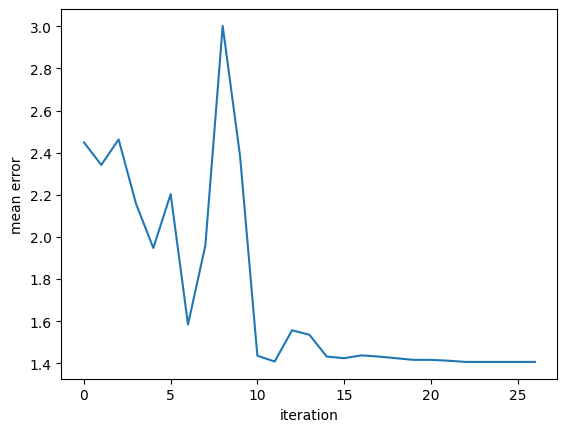

In [8]:
## define and initialize global variables
# #changed in the main
N_LAYER= 1 #6
NQ=21
nqubits=NQ
#H4='24*s0*s1 + 24*s0*s2*s3 + 48*s0*s2 + 48*s0*s3 + 24*s0*s4*s5 + 48*s0 + 8*s1*s2*s3 + 16*s1*s2 + 16*s1*s3 + 8*s1*s4*s5 + 16*s1 + 8*s2*s3*s4*s5 + 48*s2*s3 + 16*s2*s4*s5 + 48*s2 + 16*s3*s4*s5 + 48*s3 + 16*s4*s5 + 96'
#H4='s0+ s1+ s2+ s0*s1 +s1*s2 + s1*s2*s3 +s0*s1*s2*s3-1'
#U2Q4='s0*s1 + s0*s2+ s1*s2+ s1*s3 +s2*s3-1'
U2Q4='s0*s1 + s0*s2+ s1*s2+ s1*s3 + s2*s3-1'
##################
vObj=[]
vShots=[]
vCorrect=[]
GEN_SOL=[]
if __name__ == '__main__':
    #fpath='../hamiltonians-williamson/'
    gIter=0
    # //// hanya order 68 -> N=6
    NQ=4 #6  # number of qubits
    #print('order->', M, 'nqubits->', NQ)
    nqubits=NQ
    #-- text expression of Hamiltonian
    Etxt=U2Q4 #H4
    Es=sympify(Etxt)
    ##
    qx=efunct_2_qidx(Es)
    ##--create quantum circuits from terms
    NLAYER= 1#int(1.5*NQ*NQ) #NQ*NQ #NQ*NQ #NQ*4 #NQ*5 #1 #10 #upto 10 layer is ok for orde-68
    # //////////////////////////////////////
    # //// remark/remove seed for repeated experiments
    # //////////////////////////////////////
    RSEED=2 #2,3,5,7,11,13,17,19,23,29>>NQ
    # //////////////////////////////////////
    random.seed(RSEED)
    theta0=[]
    for i in range (0,2*NLAYER):
      theta0.append(random.uniform(-1.0*3.14, 1.0*3.14))
    #
    expectation = get_expectation(p=1)
    ## minimize the expectation
    #
    #res = minimize(expectation,
    #                  theta0,
    #                  method='COBYLA')
    #'''
    res = minimize(expectation,
                      theta0,
                      method='COBYLA',
                      options={'xatol': 1e-18, 'disp': True}
                      )
    #'''
    print(res)
    print('/////////////////////////////////////////////////')
    print('N-LAYER = ', NLAYER)

    #///// RESULTS DURING ITERATION /////
    print('\n** results during iteration**')
    ttl_shots=0
    ttl_csol=0
    for m in range(0, len(vShots)):
        ttl_shots= ttl_shots + vShots[m]
        ttl_csol = ttl_csol + vCorrect[m]
    #///
    print('Total Shots->', ttl_shots, 'Total Correct->', ttl_csol)
    print('Prob of random algorithm (before acc all sol) >> ', 1/2**NQ)
    print('Prob of QAOA>>', ttl_csol/ttl_shots)

    print('\n **results after iteration**')
    #-- DISPLAY RESULTS
    #backend = Aer.get_backend('aer_simulator')
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = 4*512
    # --
    qc_res=create_qaoa_circ_from_terms(qx,nqubits,res.x)
    #--
    counts = backend.run(qc_res, seed_simulator=RSEED).result().get_counts()
    #///
    print('Total distinct solutions->', len(counts))
    #--- cek hadamard
    # /// from a set of candidate
    cntr=Counter(counts)

    # //////////////////////////////////////////
    # ---analisis---
    # jumlah solusi dari NSOL- frekuensi tertinggi
    #//// selected solutions: most frequent ///
    NSOL= len(counts) # int(len(counts)/2.0) #20*25 # 10 #int(2**NQ/10)
    vbs=cntr.most_common(NSOL) # get solution candidates
    # /// scan all solution candidates
    cnt_sol=0  # solution counter
    cnt_freq=0 # frequency of solution
    TOT_SOL=0
    min_obj=1000*1000
    for m in range(0,NSOL):
        tbs=vbs[m][0] # bitstring of solutions
        #---
        tfr=vbs[m][1] # frequency
        TOT_SOL=TOT_SOL+tfr
        #vobj=obj_H4(tbs) #     obj_si_bs
        vobj=obj_U2Q4(tbs) #     obj_si_bs
        #---
        #print(tbs,':',tfr, '-> obj:', vobj)
        if vobj<min_obj:
          min_obj=vobj
          min_sol=tbs
        # ////////////
        #print(tbs,':',tfr, '-> obj:', vobj, 'min_obj->', min_obj)
        # ////////////
        #
        if vobj<1:
          cnt_sol=+1
          cnt_freq=cnt_freq+tfr
          sol=tbs
    #--
    if cnt_sol<1:
      print('NO EXACT solution among the most frequent')
      #sol=tbs
      sol=min_sol
    else:
      print('Number of correct solution found->', cnt_freq, 'among', TOT_SOL)
    #--
    ##/// solution from GEN_SOL
    if len(GEN_SOL)>0:
        bs=GEN_SOL[0]
    else:
        bs=sol
    #--
    #bs='101110001101001111010'
    print('tbs->', bs)

    #////////////////
    # plot learning curve
    plt.plot(vObj)
    plt.xlabel("iteration")
    plt.ylabel("mean error")
    #---
    #/// plot histogram
    #plot_histogram(counts)

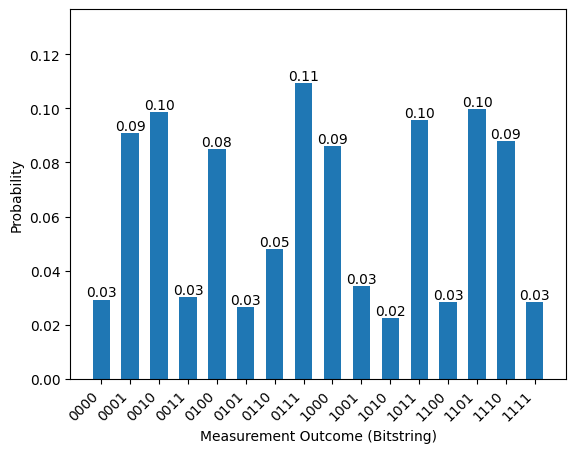

In [9]:
## plot histogram
# Total shots
total = sum(counts.values())

# Sort the labels
sorted_labels = sorted(counts.keys())

# Get probabilities in sorted order
probs = [counts[label] / total for label in sorted_labels]

# Plot
plt.bar(sorted_labels, probs, width=0.6)

# Label the axes
plt.xlabel('Measurement Outcome (Bitstring)')
plt.ylabel('Probability')
#plt.title('Measurement Results')
plt.ylim(0, 1.25*max(probs))
#plt.grid(axis='y', linestyle='--', alpha=0.7)
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')  # rotate 45 derajat dan rata kanan

# Add text labels on top of bars
for i in range(len(sorted_labels)):
    plt.text(sorted_labels[i], probs[i] + 0*0.02, f'{probs[i]:.2f}',
             ha='center', va='bottom', fontsize=10)

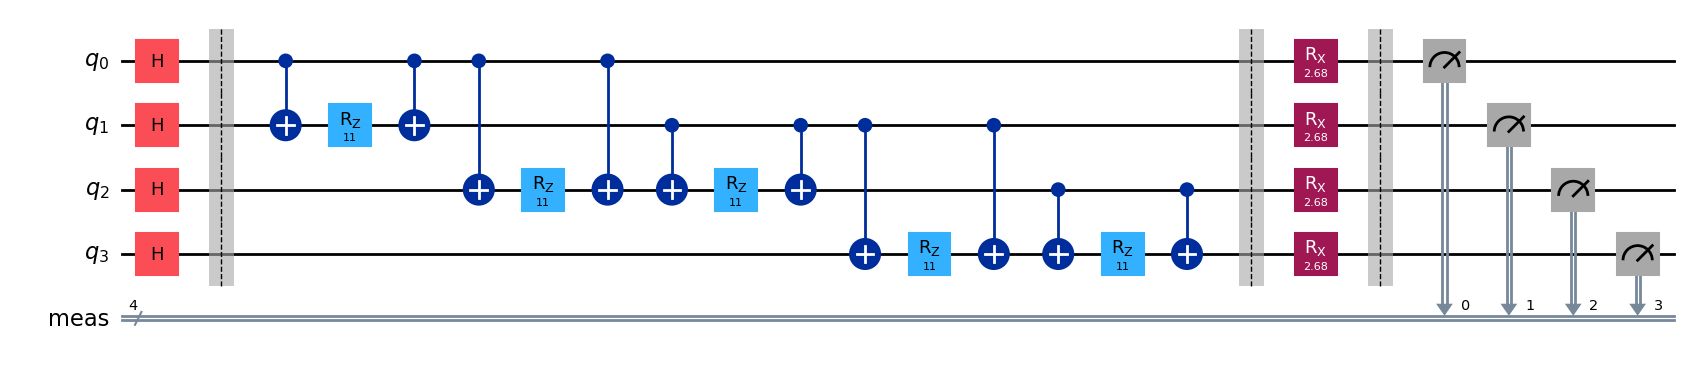

In [10]:
### draw quantum circuit

qc_res.draw(output='mpl')